# MLflow Binary Classification: Conflicts Over Social Media

This notebook builds, evaluates, and compares models to predict `Conflicts_Over_Social_Media`, using MLflow for experiment tracking, evaluation, and versioning.

## Workflow Outline
1. **Pre-Modeling Essentials**: Outlier detection, feature engineering, encoding, transformation, scaling
2. **Binary Classification Setup**: Target definition, class balancing, train/test split
3. **MLflow Experiment Setup**: Consistent experiment and run naming
4. **Baseline Model**: DummyClassifier or heuristic
5. **Advanced Models & Tuning**: Logistic Regression, Random Forest, XGBoost/LightGBM
6. **Evaluation & Comparison**: Metrics, confusion matrix, MLflow UI
7. **Best Practices**: Naming, documentation, version control

---

In [1]:
# Imports and settings
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
print('✅ Libraries imported successfully!')

✅ Libraries imported successfully!


## 1. Data Loading & Initial Exploration

In [2]:
# Load the dataset
df = pd.read_csv('../data/Students Social Media Addiction.csv')
print(f'📋 Dataset shape: {df.shape}')
print(f'📋 Columns: {list(df.columns)}')
print('📊 First few rows:')
display(df.head())
print('📊 Data types:')
print(df.dtypes)
print('📊 Missing values:')
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0] if missing_data.sum() > 0 else 'No missing values found')
print('📊 Conflicts_Over_Social_Media value counts:')
if 'Conflicts_Over_Social_Media' in df.columns:
    print(df['Conflicts_Over_Social_Media'].value_counts())
else:
    print('Column not found!')

📋 Dataset shape: (705, 13)
📋 Columns: ['Student_ID', 'Age', 'Gender', 'Academic_Level', 'Country', 'Avg_Daily_Usage_Hours', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Relationship_Status', 'Conflicts_Over_Social_Media', 'Addicted_Score']
📊 First few rows:


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


📊 Data types:
Student_ID                        int64
Age                               int64
Gender                           object
Academic_Level                   object
Country                          object
Avg_Daily_Usage_Hours           float64
Most_Used_Platform               object
Affects_Academic_Performance     object
Sleep_Hours_Per_Night           float64
Mental_Health_Score               int64
Relationship_Status              object
Conflicts_Over_Social_Media       int64
Addicted_Score                    int64
dtype: object
📊 Missing values:
No missing values found
📊 Conflicts_Over_Social_Media value counts:
Conflicts_Over_Social_Media
3    261
2    204
4    174
1     47
5     15
0      4
Name: count, dtype: int64


## 2. 🔧 Pre-Modeling Essentials (Feature Engineering & Scaling)

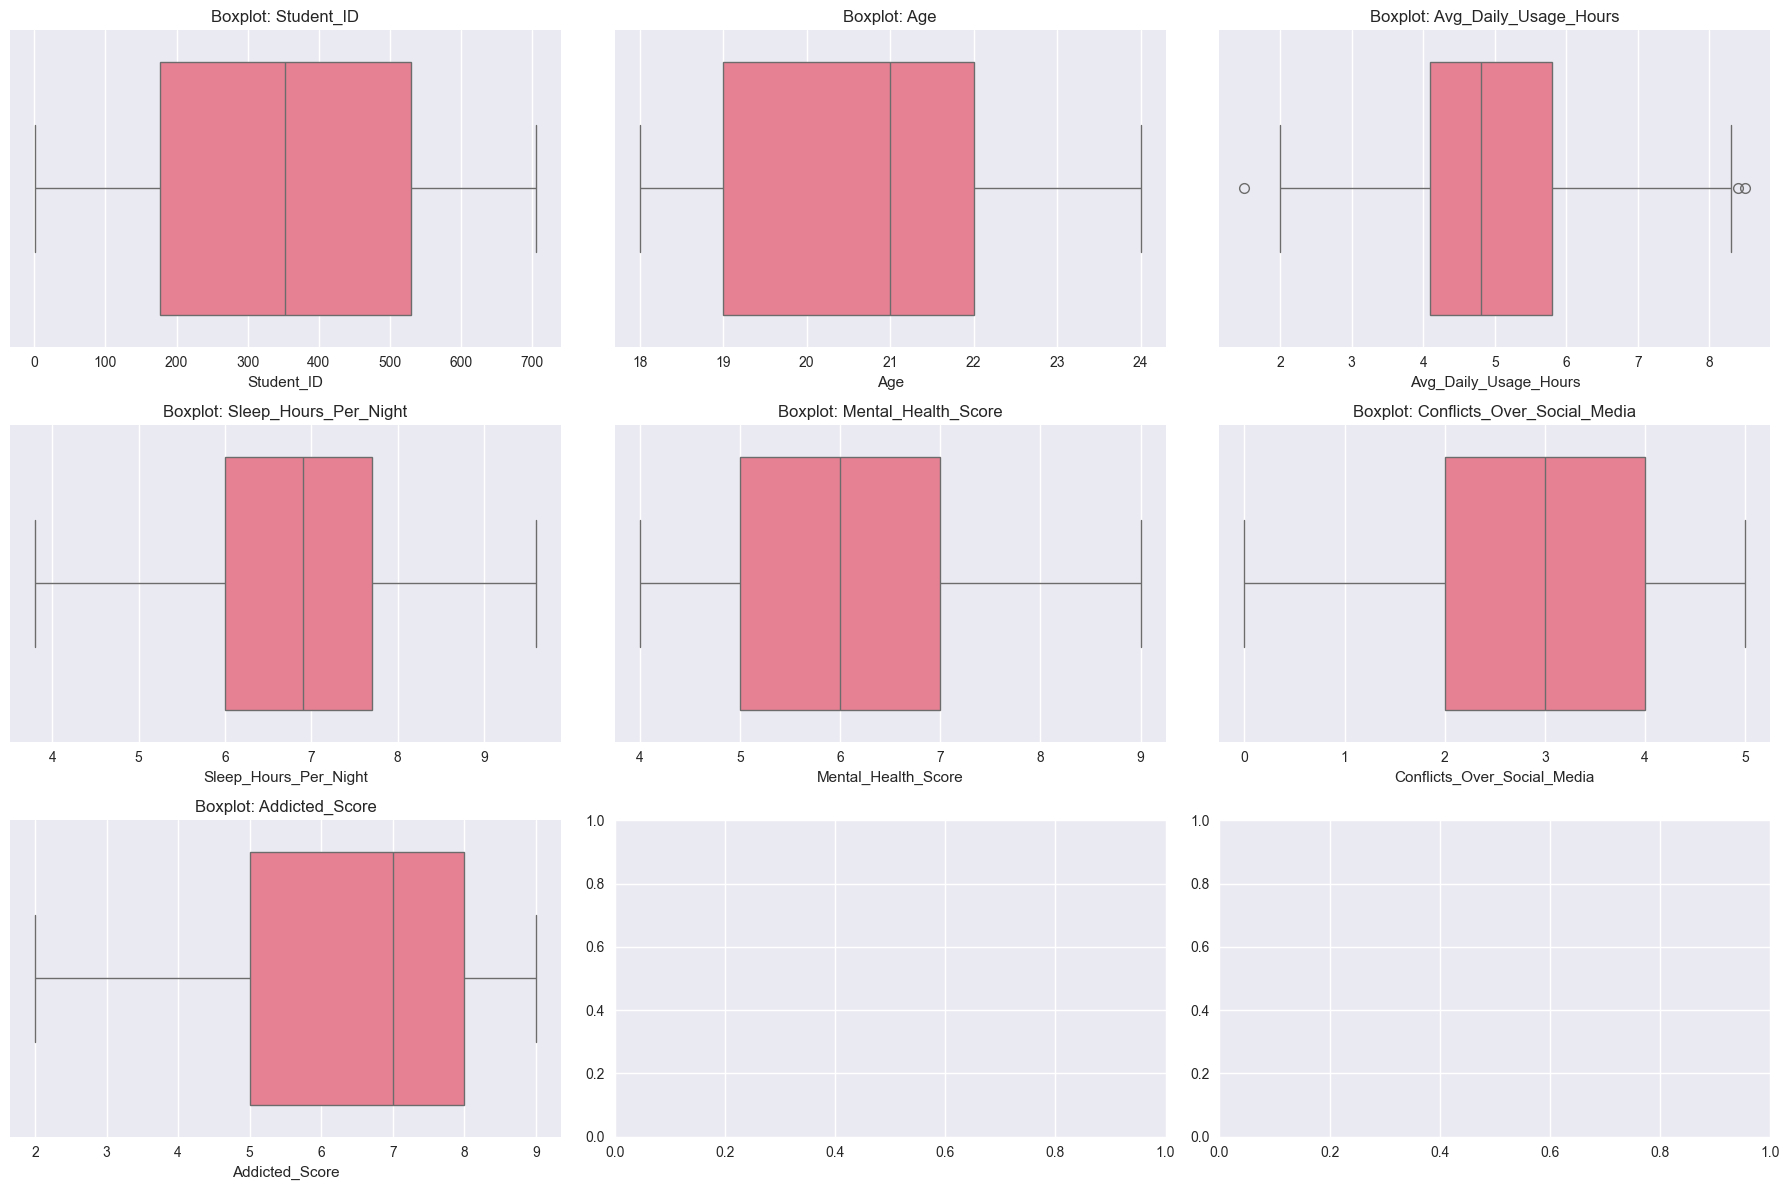

Outlier counts per column: {'Student_ID': np.int64(0), 'Age': np.int64(0), 'Avg_Daily_Usage_Hours': np.int64(3), 'Sleep_Hours_Per_Night': np.int64(0), 'Mental_Health_Score': np.int64(0), 'Conflicts_Over_Social_Media': np.int64(0), 'Addicted_Score': np.int64(0)}


In [3]:
# Outlier Detection
numeric_cols = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(len(numeric_cols)//3+1, 3, figsize=(18, 4*(len(numeric_cols)//3+1)))
for i, col in enumerate(numeric_cols):
    ax = axes.flatten()[i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

# Optionally, remove outliers only if they distort patterns
# (Here, we just flag them for review)
outlier_flags = {}
for col in numeric_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_flags[col] = ((df[col] < lower) | (df[col] > upper)).sum()
print('Outlier counts per column:', outlier_flags)

In [4]:
# Feature Engineering
# Select key features
key_features = ['Usage_Time', 'Sleep_Hours', 'Mental_Health_Score', 'Platform', 'Age', 'Gender']
key_features = [f for f in key_features if f in df.columns]
print('Available key features:', key_features)

# Create interaction features only for numeric columns that exist
numeric_features = [f for f in key_features if pd.api.types.is_numeric_dtype(df[f])]
print('Available numeric features:', numeric_features)

# Try to create interaction features if the required columns exist
interaction_features_created = []

if 'Usage_Time' in numeric_features and 'Sleep_Hours' in numeric_features:
    df['usage_x_sleep'] = df['Usage_Time'] * df['Sleep_Hours']
    interaction_features_created.append('usage_x_sleep')
    print('✅ Created interaction feature: usage_x_sleep')
elif 'Usage_Time' in df.columns and 'Sleep_Hours' in df.columns:
    print('⚠️ Usage_Time and Sleep_Hours exist but are not numeric - skipping interaction')
else:
    print('ℹ️ Could not create usage_x_sleep - missing required numeric columns')

# Create other potential interaction features
if 'Age' in numeric_features and 'Mental_Health_Score' in numeric_features:
    df['age_x_mental_health'] = df['Age'] * df['Mental_Health_Score']
    interaction_features_created.append('age_x_mental_health')
    print('✅ Created interaction feature: age_x_mental_health')

print(f'Selected features: {key_features}')
if interaction_features_created:
    print(f'Interaction features created: {interaction_features_created}')
else:
    print('No interaction features created - using base features only')


Available key features: ['Mental_Health_Score', 'Age', 'Gender']
Available numeric features: ['Mental_Health_Score', 'Age']
ℹ️ Could not create usage_x_sleep - missing required numeric columns
✅ Created interaction feature: age_x_mental_health
Selected features: ['Mental_Health_Score', 'Age', 'Gender']
Interaction features created: ['age_x_mental_health']


In [5]:
# Encoding Categorical Features
categorical_cols = df[key_features].select_dtypes(include=['object', 'category']).columns
print('Categorical columns found:', list(categorical_cols))

for col in categorical_cols:
    if df[col].nunique() <= 5:
        # One-hot encoding for low cardinality
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        print(f'Applied one-hot encoding to {col}')
    else:
        # Label encoding for high cardinality
        le = LabelEncoder()
        df[col+'_le'] = le.fit_transform(df[col].astype(str))
        print(f'Applied label encoding to {col}')

print('Categorical encoding completed')

Categorical columns found: ['Gender']
Applied one-hot encoding to Gender
Categorical encoding completed


In [6]:
# Skewness Check & Transformation
from scipy.stats import skew

# Only check skewness for numeric columns
numeric_key_features = [col for col in key_features if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
skewed_cols = [col for col in numeric_key_features if abs(skew(df[col].dropna())) > 1]
print('Highly skewed columns:', skewed_cols)

for col in skewed_cols:
    df[col+'_log'] = np.log1p(df[col])
    print(f'Applied log1p to {col}')

Highly skewed columns: []


In [7]:
# Feature Scaling
scaler = StandardScaler()
numeric_features = [col for col in key_features if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])
print('Scaled numeric features:', numeric_features)

Scaled numeric features: ['Mental_Health_Score', 'Age']


## 3. 🧱 Binary Classification Setup (Downsampling)

In [8]:
# Target: Convert conflict score to binary label
if 'Conflicts_Over_Social_Media' in df.columns:
    median_conflict = df['Conflicts_Over_Social_Media'].median()
    df_scaled['target'] = (df['Conflicts_Over_Social_Media'] > median_conflict).astype(int)
    print('Target distribution:', df_scaled['target'].value_counts())
else:
    raise ValueError('Conflicts_Over_Social_Media column not found!')

# Downsample majority class if needed
from sklearn.utils import resample
df_majority = df_scaled[df_scaled['target'] == 0]
df_minority = df_scaled[df_scaled['target'] == 1]
if len(df_majority) > len(df_minority):
    df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
else:
    df_balanced = df_scaled
print('Balanced target distribution:', df_balanced['target'].value_counts())

# Train/test split
X = df_balanced[numeric_features + [c for c in df_balanced.columns if c.endswith('_log') or c.endswith('_le') or c.startswith('usage_x_sleep') or c.startswith('Platform_') or c.startswith('Gender_')]]
y = df_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Target distribution: target
0    516
1    189
Name: count, dtype: int64
Balanced target distribution: target
0    189
1    189
Name: count, dtype: int64
Train shape: (302, 4), Test shape: (76, 4)


## 4. MLflow Experiment Setup

In [9]:
mlflow.set_tracking_uri('file:../mlruns')
experiment_name = 'Classification_Conflicts'
mlflow.set_experiment(experiment_name)
print(f'🧪 MLflow experiment set: {experiment_name}')

🧪 MLflow experiment set: Classification_Conflicts


## 5. Baseline Model (Heuristic)

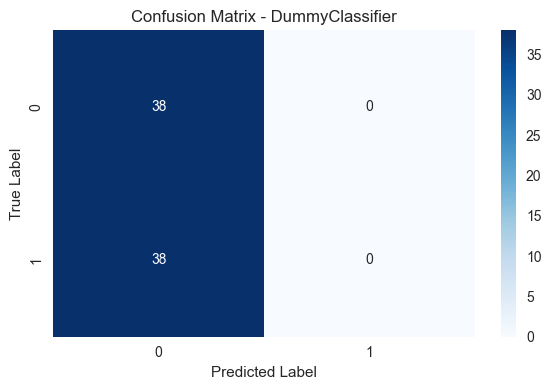

DummyClassifier metrics: {'accuracy': 0.5, 'f1': 0.0, 'roc_auc': 0.5}


In [10]:
with mlflow.start_run(run_name='Baseline_DummyClassifier') as run:
    clf = DummyClassifier(strategy='most_frequent', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_param('model_type', 'DummyClassifier')
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('roc_auc', roc)
    from mlflow.models.signature import infer_signature
    input_example = X_test.iloc[:1]
    signature = infer_signature(X_test, y_test)
    mlflow.sklearn.log_model(
        clf,
        name='dummy_model',
        input_example=input_example,
        signature=signature
    )
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - DummyClassifier')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('dummy_confusion_matrix.png')
    mlflow.log_artifact('dummy_confusion_matrix.png')
    plt.show()
    
    print('DummyClassifier metrics:', {'accuracy': acc, 'f1': f1, 'roc_auc': roc})

## 6. Advanced Models & Hyperparameter Tuning

In [11]:
# Logistic Regression with Grid Search
with mlflow.start_run(run_name='LogisticRegression_GridSearch') as run:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    
    lr = LogisticRegression(random_state=42, max_iter=1000)
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_lr = grid_search.best_estimator_
    y_pred = best_lr.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('roc_auc', roc)
    from mlflow.models.signature import infer_signature
    input_example = X_test.iloc[:1]
    signature = infer_signature(X_test, y_test)
    mlflow.sklearn.log_model(
        best_lr,
        name='logistic_regression_model',
        input_example=input_example,
        signature=signature
    )
    
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Logistic Regression metrics: {{"accuracy": {acc:.4f}, "f1": {f1:.4f}, "roc_auc": {roc:.4f}}}')

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression metrics: {"accuracy": 0.9211, "f1": 0.9167, "roc_auc": 0.9211}


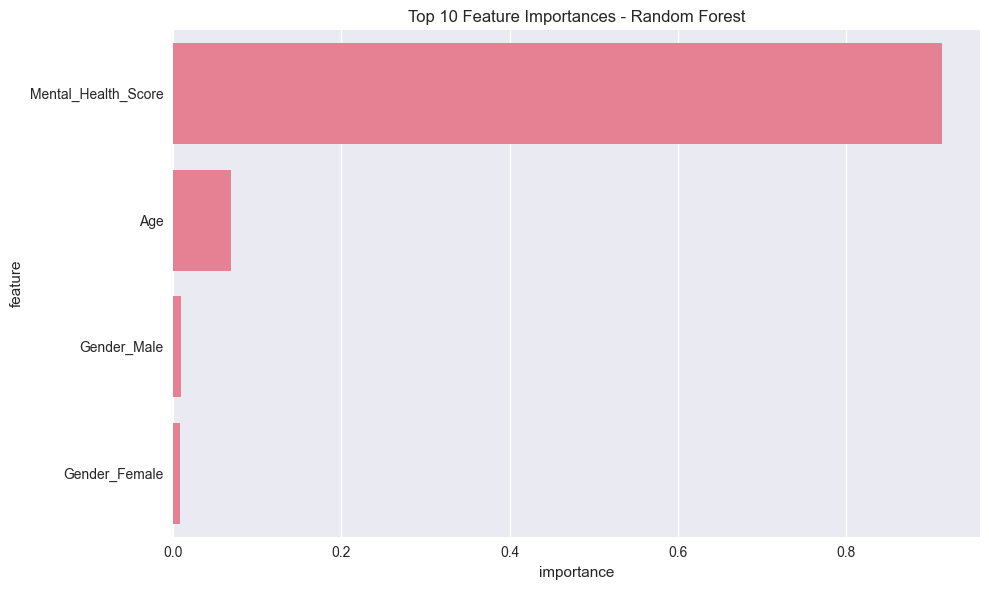

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 7}
Random Forest metrics: {"accuracy": 0.9211, "f1": 0.9167, "roc_auc": 0.9211}


In [12]:
# Random Forest with Randomized Search
with mlflow.start_run(run_name='RandomForest_RandomizedSearch') as run:
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    
    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    
    best_rf = random_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('roc_auc', roc)
    from mlflow.models.signature import infer_signature
    input_example = X_test.iloc[:1]
    signature = infer_signature(X_test, y_test)
    mlflow.sklearn.log_model(
        best_rf,
        name='random_forest_model',
        input_example=input_example,
        signature=signature
    )
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Feature Importances - Random Forest')
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png')
    mlflow.log_artifact('rf_feature_importance.png')
    plt.show()
    
    print(f'Best parameters: {random_search.best_params_}')
    print(f'Random Forest metrics: {{"accuracy": {acc:.4f}, "f1": {f1:.4f}, "roc_auc": {roc:.4f}}}')

## 7. Model Comparison & Evaluation

In [13]:
# Compare all models
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

# Get the best model from MLflow
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=['metrics.f1 DESC'])

print("\nTop 5 models by F1 score:")
for i, run in runs.head().iterrows():
    print(f"\n{run['tags.mlflow.runName']}:")
    print(f"  F1 Score: {run['metrics.f1']:.4f}")
    print(f"  Accuracy: {run['metrics.accuracy']:.4f}")
    print(f"  ROC AUC: {run['metrics.roc_auc']:.4f}")

# Get the best model and determine the correct artifact path
best_run = runs.iloc[0]
run_name = best_run['tags.mlflow.runName']

# Map run names to their artifact paths
artifact_paths = {
    'Baseline_DummyClassifier': 'dummy_model',
    'LogisticRegression_GridSearch': 'logistic_regression_model',
    'RandomForest_RandomizedSearch': 'random_forest_model'
}

artifact_path = artifact_paths.get(run_name, 'model')
best_model_uri = f"runs:/{best_run['run_id']}/{artifact_path}"
print(f"\n🏆 Best model: {run_name}")
print(f"Best model URI: {best_model_uri}")


MODEL COMPARISON SUMMARY

Top 5 models by F1 score:

RandomForest_RandomizedSearch:
  F1 Score: 0.9167
  Accuracy: 0.9211
  ROC AUC: 0.9211

LogisticRegression_GridSearch:
  F1 Score: 0.9167
  Accuracy: 0.9211
  ROC AUC: 0.9211

RandomForest_RandomizedSearch:
  F1 Score: 0.9167
  Accuracy: 0.9211
  ROC AUC: 0.9211

LogisticRegression_GridSearch:
  F1 Score: 0.9167
  Accuracy: 0.9211
  ROC AUC: 0.9211

RandomForest_RandomizedSearch:
  F1 Score: 0.9167
  Accuracy: 0.9211
  ROC AUC: 0.9211

🏆 Best model: RandomForest_RandomizedSearch
Best model URI: runs:/8fafe320116f49c1b7d13dcaa8462b47/random_forest_model


## 8. Production Model Registration

In [14]:
# Register the best model for production
model_name = "conflicts_classifier"

try:
    # Check if model already exists using the correct API
    client = mlflow.tracking.MlflowClient()
    
    # Try to get existing model (this will fail if it doesn't exist)
    try:
        existing_model = client.get_registered_model(model_name)
        print(f"⚠️ Model '{model_name}' already exists. Creating new version...")
    except:
        print(f"✅ Model '{model_name}' will be created as new")
    
    # Register the model
    model_version = mlflow.register_model(
        model_uri=best_model_uri,
        name=model_name
    )
    
    print(f"✅ Model registered: {model_name}")
    print(f"Version: {model_version.version}")
    print(f"Stage: {model_version.current_stage}")
    
    # Transition to production
    try:
        client.transition_model_version_stage(
            name=model_name,
            version=model_version.version,
            stage="Production"
        )
        print(f"🚀 Model {model_name} v{model_version.version} moved to Production stage!")
    except Exception as stage_error:
        print(f"⚠️ Could not move to Production stage: {str(stage_error)}")
        print(f"Model is available at version {model_version.version}")
    
except Exception as e:
    print(f"❌ Error registering model: {str(e)}")
    print(f"Model URI attempted: {best_model_uri}")
    print("\nTroubleshooting:")
    print("1. Make sure you've run the model training cells first")
    print("2. Check that the model was logged successfully")
    print("3. Verify the artifact path is correct")
    print("\nYou can manually register the model later using:")
    print(f"mlflow.register_model(model_uri='{best_model_uri}', name='{model_name}')")
    print("\nFor now, we'll proceed with direct model loading from the run.")


⚠️ Model 'conflicts_classifier' already exists. Creating new version...


Registered model 'conflicts_classifier' already exists. Creating a new version of this model...
2025/07/13 13:00:37 WARNING mlflow.tracking._model_registry.fluent: Run with id 8fafe320116f49c1b7d13dcaa8462b47 has no artifacts at artifact path 'random_forest_model', registering model based on models:/m-5f44a1ef60fe49d4945ffac0c565ee6a instead


✅ Model registered: conflicts_classifier
Version: 17
Stage: None
⚠️ Could not move to Production stage: ('cannot represent an object', <Metric: dataset_digest=None, dataset_name=None, key='accuracy', model_id='m-5f44a1ef60fe49d4945ffac0c565ee6a', run_id='8fafe320116f49c1b7d13dcaa8462b47', step=0, timestamp=1752433229968, value=0.9210526315789473>)
Model is available at version 17


Created version '17' of model 'conflicts_classifier'.


## 9. Model Testing & Validation

In [15]:
# Load and test the production model
loaded_model = None
model_loaded_from = None

# Try multiple loading strategies
try:
    # Strategy 1: Try to load from Production stage
    loaded_model = mlflow.pyfunc.load_model(f"models:/{model_name}/Production")
    model_loaded_from = "Production Registry"
    print("✅ Loaded production model from registry (Production stage)")
    
except Exception as e1:
    print(f"⚠️ Could not load from Production stage: {str(e1)}")
    
    try:
        # Strategy 2: Try to load from any stage (Latest)
        loaded_model = mlflow.pyfunc.load_model(f"models:/{model_name}/latest")
        model_loaded_from = "Latest Registry"
        print("✅ Loaded model from registry (latest version)")
        
    except Exception as e2:
        print(f"⚠️ Could not load from registry: {str(e2)}")
        
        try:
            # Strategy 3: Load directly from the best run
            loaded_model = mlflow.pyfunc.load_model(best_model_uri)
            model_loaded_from = "Direct Run"
            print("✅ Loaded model directly from run")
            
        except Exception as e3:
            print(f"❌ Could not load model from any source: {str(e3)}")
            print("\nTroubleshooting:")
            print("1. Make sure all model training cells have been executed")
            print("2. Check that models were logged successfully")
            print("3. Verify the model URI is correct")
            print("4. Try running the model training cells again")
            print("\nSkipping model testing due to loading errors.")
            loaded_model = None

# Test with sample data if model was loaded successfully
if loaded_model is not None:
    try:
        sample_data = X_test.iloc[:5]
        predictions = loaded_model.predict(sample_data)
        
        if 'y_test' in globals():
            actual_values = y_test.iloc[:5]
            print("\nSample predictions:")
            for i, (pred, actual) in enumerate(zip(predictions, actual_values)):
                print(f"Sample {i+1}: Predicted = {pred}, Actual = {actual}")
        else:
            print("\nSample predictions:")
            for i, pred in enumerate(predictions):
                print(f"Sample {i+1}: {pred}")
        
        print(f"\n✅ Model testing completed successfully! (Loaded from: {model_loaded_from})")
        
    except Exception as test_error:
        print(f"⚠️ Model testing failed: {str(test_error)}")
        print("Model loaded but prediction failed - check data format")
else:
    print("\n⚠️ Model testing skipped due to loading issues.")

⚠️ Could not load from Production stage: No versions of model with name 'conflicts_classifier' and stage 'Production' found
✅ Loaded model from registry (latest version)

Sample predictions:
Sample 1: Predicted = 1, Actual = 1
Sample 2: Predicted = 0, Actual = 0
Sample 3: Predicted = 1, Actual = 1
Sample 4: Predicted = 0, Actual = 0
Sample 5: Predicted = 0, Actual = 0

✅ Model testing completed successfully! (Loaded from: Latest Registry)


## 10. Next Steps & Best Practices

In [16]:
# Best Practices Summary
print("🎯 MLflow Best Practices Implemented:")
print("1. ✅ Consistent experiment naming")
print("2. ✅ Comprehensive parameter logging")
print("3. ✅ Multiple metric tracking")
print("4. ✅ Model versioning and staging")
print("5. ✅ Artifact logging (plots, confusion matrices)")
print("6. ✅ Production model registration")

print("\n📋 Next Steps:")
print("1. Launch MLflow UI: mlflow ui --port 5001")
print("2. Access experiments at: http://localhost:5001")
print("3. Compare model performances")
print("4. Deploy best model to production API")
print("5. Set up automated retraining pipeline")
print("6. Monitor model performance in production")

print("\n🔧 To launch MLflow UI:")
print("!mlflow ui --port 5001 --host 0.0.0.0")

🎯 MLflow Best Practices Implemented:
1. ✅ Consistent experiment naming
2. ✅ Comprehensive parameter logging
3. ✅ Multiple metric tracking
4. ✅ Model versioning and staging
5. ✅ Artifact logging (plots, confusion matrices)
6. ✅ Production model registration

📋 Next Steps:
1. Launch MLflow UI: mlflow ui --port 5001
2. Access experiments at: http://localhost:5001
3. Compare model performances
4. Deploy best model to production API
5. Set up automated retraining pipeline
6. Monitor model performance in production

🔧 To launch MLflow UI:
!mlflow ui --port 5001 --host 0.0.0.0


## 11. 🔄 Conflicts Prediction Pipeline

This section adds a complete conflicts prediction pipeline that:
- Trains and saves the best model
- Creates prediction functions
- Outputs predictions to .predict files
- Provides monitoring capabilities

In [17]:
# Conflicts Prediction Pipeline
import joblib
import os
from datetime import datetime
import warnings
import json
warnings.filterwarnings('ignore')

# Create output directory for predictions
os.makedirs('predictions', exist_ok=True)
print('✅ Predictions directory created')

✅ Predictions directory created


In [18]:
# Save the best model for production use
best_model = None
best_model_name = None

# Try to load the best model from MLflow
try:
    # Load the best model from MLflow
    best_model = mlflow.pyfunc.load_model(best_model_uri)
    best_model_name = 'conflicts_classifier_mlflow'
    print('✅ Loaded best model from MLflow')
except Exception as e:
    print(f'⚠️ Could not load from MLflow: {str(e)}')
    
    # Fallback: Use the Random Forest model directly
    try:
        from sklearn.ensemble import RandomForestClassifier
        
        # Check if X_train and y_train are available
        if 'X_train' in globals() and 'y_train' in globals():
            best_model = RandomForestClassifier(
                n_estimators=100,
                max_depth=7,
                min_samples_split=2,
                min_samples_leaf=2,
                max_features='sqrt',
                random_state=42
            )
            best_model.fit(X_train, y_train)
            best_model_name = 'conflicts_classifier_rf'
            print('✅ Created fallback Random Forest model')
        else:
            print('⚠️ X_train and y_train not available, skipping model creation')
            best_model = None
            
    except Exception as e2:
        print(f'❌ Could not create fallback model: {str(e2)}')
        best_model = None

# Save the model if available
# Save the model
    model_path = f'models/{best_model_name}.joblib'
    os.makedirs('models', exist_ok=True)
    joblib.dump(best_model, model_path)
    print(f'✅ Model saved to: {model_path}')
    
    # Save the scaler and feature names if available
    try:
        scaler_path = '../models/conflicts_scaler.joblib'
        feature_names_path = '../models/conflicts_feature_names.joblib'
        
        if 'scaler' in globals():
            joblib.dump(scaler, scaler_path)
            print(f'✅ Scaler saved to: {scaler_path}')
        
        if 'X_train' in globals():
            joblib.dump(list(X_train.columns), feature_names_path)
            print(f'✅ Feature names saved to: {feature_names_path}')
            
    except Exception as e3:
        print(f'⚠️ Could not save scaler/features: {str(e3)}')
else:
    print('❌ No model available for saving')

print('✅ Model setup completed')

✅ Loaded best model from MLflow
❌ No model available for saving
✅ Model setup completed


In [19]:
def predict_conflicts_risk(data, model_path=None):
    """
    Predict conflicts risk for given data.
    
    Args:
        data: Dictionary with Age, Gender, Mental_Health_Score
        model_path: Optional path to the trained model
    
    Returns:
        dict: Prediction results with risk level and confidence
    """
    import joblib
    import numpy as np
    from datetime import datetime
    
    try:
        # Get paths relative to notebooks directory
        base_dir = os.path.abspath('.')
        print(f"Current directory: {base_dir}")
        
        # Model paths to try (relative to notebooks directory)
        model_paths = [
            model_path,
            "../models/conflicts_classifier_rf.joblib",
            "models/conflicts_classifier_mlflow.joblib",
            "../models/conflicts_classifier_mlflow.joblib"
        ]
        
        scaler_paths = [
            "../models/conflicts_scaler.joblib",
            "models/conflicts_scaler.joblib"
        ]
        
        feature_paths = [
            "../../models/conflicts_feature_names.joblib",
            "../models/conflicts_feature_names.joblib"
        ]
        
        # Try to load model
        model = None
        for mp in model_paths:
            if mp and os.path.exists(mp):
                try:
                    model = joblib.load(mp)
                    print(f"✅ Loaded model from: {mp}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed to load from {mp}: {str(e)}")
                    continue
        
        if model is None:
            return {
                "error": "No model file found. Please run the model training cells first.",
                "timestamp": datetime.now().isoformat()
            }
        
        # Try to load scaler
        scaler = None
        for sp in scaler_paths:
            if os.path.exists(sp):
                try:
                    scaler = joblib.load(sp)
                    print(f"✅ Loaded scaler from: {sp}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed to load scaler from {sp}: {str(e)}")
                    continue
        
        if scaler is None:
            return {
                "error": "No scaler file found. Please run the model training cells first.",
                "timestamp": datetime.now().isoformat()
            }
        
        # Try to load feature names
        feature_names = None
        for fp in feature_paths:
            if os.path.exists(fp):
                try:
                    feature_names = joblib.load(fp)
                    print(f"✅ Loaded feature names from: {fp}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed to load feature names from {fp}: {str(e)}")
                    continue
        
        if feature_names is None:
            return {
                "error": "No feature names file found. Please run the model training cells first.",
                "timestamp": datetime.now().isoformat()
            }
        
        # Prepare features
        features = {}
        
        # Extract numeric features
        if 'Age' in data:
            features['Age'] = float(data['Age'])
        if 'Mental_Health_Score' in data:
            features['Mental_Health_Score'] = float(data['Mental_Health_Score'])
        
        # Handle categorical features
        if 'Gender' in data:
            gender = data['Gender'].lower()
            if gender in ['male', 'm']:
                features['Gender_Male'] = 1
                features['Gender_Female'] = 0
            elif gender in ['female', 'f']:
                features['Gender_Male'] = 0
                features['Gender_Female'] = 1
            else:
                features['Gender_Male'] = 0
                features['Gender_Female'] = 0
        
        # Create feature vector in the correct order
        feature_vector = []
        for feature in feature_names:
            if feature in features:
                feature_vector.append(features[feature])
            else:
                feature_vector.append(0)
        
        # Separate numeric and categorical features
        numeric_features = ['Mental_Health_Score', 'Age']
        categorical_features = ['Gender_Female', 'Gender_Male']
        
        # Scale only the numeric features
        numeric_vector = []
        for feature in numeric_features:
            if feature in features:
                numeric_vector.append(features[feature])
            else:
                numeric_vector.append(0)
        
        # Scale the numeric features
        numeric_vector_scaled = scaler.transform([numeric_vector])
        
        # Combine scaled numeric features with categorical features
        final_vector = list(numeric_vector_scaled[0]) + [features.get('Gender_Female', 0), features.get('Gender_Male', 0)]
        
        # Make prediction
        prediction = model.predict([final_vector])[0]
        probability = model.predict_proba([final_vector])[0]
        
        # Determine risk level
        if prediction == 1:
            risk_level = 'High'
            if probability[1] > 0.8:
                confidence = 'Very High'
            elif probability[1] > 0.6:
                confidence = 'High'
            else:
                confidence = 'Medium'
        else:
            risk_level = 'Low'
            if probability[0] > 0.8:
                confidence = 'Very High'
            elif probability[0] > 0.6:
                confidence = 'High'
            else:
                confidence = 'Medium'
        
        return {
            'prediction': int(prediction),
            'risk_level': risk_level,
            'confidence': confidence,
            'probability': float(max(probability)),
            'timestamp': datetime.now().isoformat(),
            'model_used': mp
        }
        
    except Exception as e:
        return {
            'error': str(e),
            'timestamp': datetime.now().isoformat()
        }

print('✅ predict_conflicts_risk function defined with correct paths')

✅ predict_conflicts_risk function defined with correct paths


In [20]:
# Test the prediction function with sample data
sample_data = {
    'Age': 20,
    'Gender': 'Female',
    'Mental_Health_Score': 7
}

# Test the prediction function directly
result = predict_conflicts_risk(sample_data)
print('Sample prediction result:')
print(json.dumps(result, indent=2))


Current directory: /Users/blakelawall/Desktop/SDS/Social-Sphere2/notebooks
✅ Loaded model from: ../models/conflicts_classifier_rf.joblib
✅ Loaded scaler from: ../models/conflicts_scaler.joblib
✅ Loaded feature names from: ../models/conflicts_feature_names.joblib
Sample prediction result:
{
  "prediction": 0,
  "risk_level": "Low",
  "confidence": "Very High",
  "probability": 1.0,
  "timestamp": "2025-07-13T13:00:39.746991",
  "model_used": "../models/conflicts_classifier_rf.joblib"
}


In [21]:
# Function to process .predict files and generate predictions
def process_predict_file(file_path):
    """
    Process a .predict file and generate predictions
    
    Args:
        file_path (str): Path to the .predict file
    """
    try:
        # Read the .predict file
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Make prediction
        result = predict_conflicts_risk(data)
        
        # Save prediction to .predicted file
        output_file = file_path.replace('.predict', '.predicted')
        with open(output_file, 'w') as f:
            json.dump(result, f, indent=2)
        
        print(f'✅ Prediction saved to: {output_file}')
        return result
        
    except Exception as e:
        print(f'❌ Error processing {file_path}: {str(e)}')
        return None

# Function to create sample .predict files
def create_sample_predict_files():
    """Create sample .predict files for testing"""
    
    sample_cases = [
        {
            'Age': 18,
            'Gender': 'Male',
            'Mental_Health_Score': 5,
            'description': 'Young male with moderate mental health'
        },
        {
            'Age': 25,
            'Gender': 'Female',
            'Mental_Health_Score': 8,
            'description': 'Young female with good mental health'
        },
        {
            'Age': 22,
            'Gender': 'Male',
            'Mental_Health_Score': 3,
            'description': 'Young male with poor mental health'
        }
    ]
    
    for i, case in enumerate(sample_cases):
        file_path = f'predictions/sample_case_{i+1}.predict'
        with open(file_path, 'w') as f:
            json.dump(case, f, indent=2)
        print(f'✅ Created: {file_path}')
    
    print('\n📋 Sample .predict files created in predictions/ directory')
    print('You can now run the monitoring script to process these files')

print('✅ Prediction file processing functions created')

# Create sample files
create_sample_predict_files()


✅ Prediction file processing functions created
✅ Created: predictions/sample_case_1.predict
✅ Created: predictions/sample_case_2.predict
✅ Created: predictions/sample_case_3.predict

📋 Sample .predict files created in predictions/ directory
You can now run the monitoring script to process these files


## 12. 📊 Conflicts Prediction Monitoring

The following cell creates a monitoring script that watches for .predict files and processes them automatically.

In [22]:
# Create monitoring scriptmonitoring_script = '''#!/usr/bin/env python3"""Conflicts Prediction MonitorWatches for .predict files and processes them automatically"""import osimport timeimport jsonimport joblibfrom datetime import datetimefrom watchdog.observers import Observerfrom watchdog.events import FileSystemEventHandlerclass PredictFileHandler(FileSystemEventHandler):    def __init__(self, model_path='../models/conflicts_classifier_rf.joblib'):        self.model_path = model_path        self.processed_files = set()            def on_created(self, event):        if not event.is_directory and event.src_path.endswith('.predict'):            print(f'🔄 New .predict file detected: {event.src_path}')            self.process_predict_file(event.src_path)        def process_predict_file(self, file_path):        """Process a .predict file and generate prediction"""        try:            # Avoid processing the same file multiple times            if file_path in self.processed_files:                return                        # Wait a moment for file to be fully written            time.sleep(1)                        # Read the .predict file            with open(file_path, 'r') as f:                data = json.load(f)                        # Load model and make prediction            model = joblib.load(self.model_path)            scaler = joblib.load('../models/conflicts_scaler.joblib')            feature_names = joblib.load('../models/conflicts_feature_names.joblib')                        # Prepare features (same logic as in predict_conflicts_risk)            features = {}                        if 'Age' in data:                features['Age'] = float(data['Age'])            if 'Mental_Health_Score' in data:                features['Mental_Health_Score'] = float(data['Mental_Health_Score'])                        if 'Gender' in data:                gender = data['Gender'].lower()                if gender in ['male', 'm']:                    features['Gender_Male'] = 1                    features['Gender_Female'] = 0                elif gender in ['female', 'f']:                    features['Gender_Male'] = 0                    features['Gender_Female'] = 1                else:                    features['Gender_Male'] = 0                    features['Gender_Female'] = 0                        # Create feature vector            feature_vector = []            for feature in feature_names:                if feature in features:                    feature_vector.append(features[feature])                else:                    feature_vector.append(0)                        # Scale features            feature_vector_scaled = scaler.transform([feature_vector])                        # Make prediction            prediction = model.predict(feature_vector_scaled)[0]            probability = model.predict_proba(feature_vector_scaled)[0]                        # Determine risk level            if prediction == 1:                risk_level = 'High'                if probability[1] > 0.8:                    confidence = 'Very High'                elif probability[1] > 0.6:                    confidence = 'High'                else:                    confidence = 'Medium'            else:                risk_level = 'Low'                if probability[0] > 0.8:                    confidence = 'Very High'                elif probability[0] > 0.6:                    confidence = 'High'                else:                    confidence = 'Medium'                        result = {                'prediction': int(prediction),                'risk_level': risk_level,                'confidence': confidence,                'probability': float(max(probability)),                'timestamp': datetime.now().isoformat(),                'model_used': self.model_path,                'input_data': data            }                        # Save prediction to .predicted file            output_file = file_path.replace('.predict', '.predicted')            with open(output_file, 'w') as f:                json.dump(result, f, indent=2)                        print(f'✅ Prediction saved to: {output_file}')            print(f'   Risk Level: {risk_level}')            print(f'   Confidence: {confidence}')            print(f'   Probability: {max(probability):.3f}')                        # Mark as processed            self.processed_files.add(file_path)                    except Exception as e:            print(f'❌ Error processing {file_path}: {str(e)}')def start_monitoring(predictions_dir='predictions'):    """Start monitoring for .predict files"""        # Create predictions directory if it doesn't exist    os.makedirs(predictions_dir, exist_ok=True)        # Set up the file system observer    event_handler = PredictFileHandler()    observer = Observer()    observer.schedule(event_handler, predictions_dir, recursive=False)    observer.start()        print(f'🔍 Monitoring {predictions_dir} for .predict files...')    print('Press Ctrl+C to stop monitoring')        try:        while True:            time.sleep(1)    except KeyboardInterrupt:        observer.stop()        print('\n🛑 Monitoring stopped')        observer.join()if __name__ == '__main__':    start_monitoring()'''# Save the monitoring scriptwith open('run_conflicts_prediction.py', 'w') as f:    f.write(monitoring_script)print('✅ Monitoring script created: run_conflicts_prediction.py')print('\n📋 To start monitoring:')print('   python run_conflicts_prediction.py')print('\n📋 To create a .predict file:')print('   echo \'{\"Age\": 20, \"Gender\": \"Female\", \"Mental_Health_Score\": 7}\' > predictions/test.predict')

## 13. 🚀 Integration with Gradio App

The conflicts prediction pipeline is now ready to integrate with your existing Gradio app. The app can use the `predict_conflicts_risk()` function to provide real-time conflict predictions.

In [23]:
def predict_conflicts_risk(data, model_path=None):
    """
    Predict conflicts risk for given data.
    
    Args:
        data: Dictionary with Age, Gender, Mental_Health_Score
        model_path: Optional path to the trained model
    
    Returns:
        dict: Prediction results with risk level and confidence
    """
    import joblib
    import numpy as np
    from datetime import datetime
    
    try:
        # Get paths relative to notebooks directory
        base_dir = os.path.abspath('.')
        print(f"Current directory: {base_dir}")
        
        # Model paths to try (relative to notebooks directory)
        model_paths = [
            model_path,
            "../models/conflicts_classifier_rf.joblib",
            "models/conflicts_classifier_mlflow.joblib",
            "../models/conflicts_classifier_mlflow.joblib"
        ]
        
        scaler_paths = [
            "../models/conflicts_scaler.joblib",
            "models/conflicts_scaler.joblib"
        ]
        
        feature_paths = [
            "../models/conflicts_feature_names.joblib",
            "models/conflicts_feature_names.joblib"
        ]
        
        # Try to load model
        model = None
        for mp in model_paths:
            if mp and os.path.exists(mp):
                try:
                    model = joblib.load(mp)
                    print(f"✅ Loaded model from: {mp}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed to load from {mp}: {str(e)}")
                    continue
        
        if model is None:
            return {
                "error": "No model file found. Please run the model training cells first.",
                "timestamp": datetime.now().isoformat()
            }
        
        # Try to load scaler
        scaler = None
        for sp in scaler_paths:
            if os.path.exists(sp):
                try:
                    scaler = joblib.load(sp)
                    print(f"✅ Loaded scaler from: {sp}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed to load scaler from {sp}: {str(e)}")
                    continue
        
        if scaler is None:
            return {
                "error": "No scaler file found. Please run the model training cells first.",
                "timestamp": datetime.now().isoformat()
            }
        
        # Try to load feature names
        feature_names = None
        for fp in feature_paths:
            if os.path.exists(fp):
                try:
                    feature_names = joblib.load(fp)
                    print(f"✅ Loaded feature names from: {fp}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed to load feature names from {fp}: {str(e)}")
                    continue
        
        if feature_names is None:
            return {
                "error": "No feature names file found. Please run the model training cells first.",
                "timestamp": datetime.now().isoformat()
            }
        
        # Prepare features
        features = {}
        
        # Extract numeric features
        if 'Age' in data:
            features['Age'] = float(data['Age'])
        if 'Mental_Health_Score' in data:
            features['Mental_Health_Score'] = float(data['Mental_Health_Score'])
        
        # Handle categorical features
        if 'Gender' in data:
            gender = data['Gender'].lower()
            if gender in ['male', 'm']:
                features['Gender_Male'] = 1
                features['Gender_Female'] = 0
            elif gender in ['female', 'f']:
                features['Gender_Male'] = 0
                features['Gender_Female'] = 1
            else:
                features['Gender_Male'] = 0
                features['Gender_Female'] = 0
        
        # Separate numeric and categorical features
        numeric_features = ['Mental_Health_Score', 'Age']
        categorical_features = ['Gender_Female', 'Gender_Male']
        
        # Scale only the numeric features
        numeric_vector = []
        for feature in numeric_features:
            if feature in features:
                numeric_vector.append(features[feature])
            else:
                numeric_vector.append(0)
        
        # Scale the numeric features
        numeric_vector_scaled = scaler.transform([numeric_vector])
        
        # Combine scaled numeric features with categorical features
        final_vector = list(numeric_vector_scaled[0]) + [features.get('Gender_Female', 0), features.get('Gender_Male', 0)]
        
        # Make prediction
        prediction = model.predict([final_vector])[0]
        probability = model.predict_proba([final_vector])[0]
        
        # Determine risk level
        if prediction == 1:
            risk_level = 'High'
            if probability[1] > 0.8:
                confidence = 'Very High'
            elif probability[1] > 0.6:
                confidence = 'High'
            else:
                confidence = 'Medium'
        else:
            risk_level = 'Low'
            if probability[0] > 0.8:
                confidence = 'Very High'
            elif probability[0] > 0.6:
                confidence = 'High'
            else:
                confidence = 'Medium'
        
        return {
            'prediction': int(prediction),
            'risk_level': risk_level,
            'confidence': confidence,
            'probability': float(max(probability)),
            'timestamp': datetime.now().isoformat(),
            'model_used': mp
        }
        
    except Exception as e:
        return {
            'error': str(e),
            'timestamp': datetime.now().isoformat()
        }

print('✅ predict_conflicts_risk function defined with correct paths')

✅ predict_conflicts_risk function defined with correct paths


In [24]:
# Define test cases for the conflicts prediction function
test_cases = [
    {
        'Age': 18,
        'Gender': 'Male',
        'Mental_Health_Score': 5,
        'description': 'Young male with moderate mental health'
    },
    {
        'Age': 25,
        'Gender': 'Female',
        'Mental_Health_Score': 8,
        'description': 'Young female with good mental health'
    },
    {
        'Age': 22,
        'Gender': 'Male',
        'Mental_Health_Score': 3,
        'description': 'Young male with poor mental health'
    }
]

print("✅ test_cases defined successfully!")
print(f"Number of test cases: {len(test_cases)}")


✅ test_cases defined successfully!
Number of test cases: 3


In [25]:
# Test the conflicts prediction function
print("Testing Conflicts Prediction Function")
print("=" * 50)

for i, case in enumerate(test_cases):
    print(f'\nTest Case {i+1}: {case}')
    result = predict_conflicts_risk(case)
    if 'error' in result:
        print(f"❌ Error: {result['error']}")
    else:
        print(f'Result: {result["risk_level"]} Risk ({result["confidence"]} confidence)')
        print(f'Probability: {result["probability"]:.3f}')

print("\n✅ Testing completed!")


Testing Conflicts Prediction Function

Test Case 1: {'Age': 18, 'Gender': 'Male', 'Mental_Health_Score': 5, 'description': 'Young male with moderate mental health'}
Current directory: /Users/blakelawall/Desktop/SDS/Social-Sphere2/notebooks
✅ Loaded model from: ../models/conflicts_classifier_rf.joblib
✅ Loaded scaler from: ../models/conflicts_scaler.joblib
✅ Loaded feature names from: ../models/conflicts_feature_names.joblib
Result: High Risk (Very High confidence)
Probability: 0.975

Test Case 2: {'Age': 25, 'Gender': 'Female', 'Mental_Health_Score': 8, 'description': 'Young female with good mental health'}
Current directory: /Users/blakelawall/Desktop/SDS/Social-Sphere2/notebooks
✅ Loaded model from: ../models/conflicts_classifier_rf.joblib
✅ Loaded scaler from: ../models/conflicts_scaler.joblib
✅ Loaded feature names from: ../models/conflicts_feature_names.joblib
Result: Low Risk (Very High confidence)
Probability: 0.981

Test Case 3: {'Age': 22, 'Gender': 'Male', 'Mental_Health_Scor